In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import numpy as np

In [2]:
color_map = {
    'solar': 'yellow',
    'solar-rooftop': 'lightgreen',
    'wind': 'lightblue',
    'battery': 'purple',
    'nuclear': 'orange',
    'natgas': 'gray',
    'oil': 'black',
    'hydrogen': 'lightpink',
    'BTES': 'red',
    'load': 'darkblue',
    'lost_load': 'darkgreen',
    'lost load': 'darkgreen',}


In [3]:
def plot_cost_scan(data_path, region, x_var, suffix='', plot_dispatch=False):
    """
    Plot the cost scan of the BTES discharge cost
    :param data_path: path to the data
    :param suffix: suffix to add to the title and figure file name
    """
    plt.figure()
    system_cost = []
    file_names = [f for f in os.listdir(data_path) if (f.endswith('.pickle') and not 'Store' in f)]
    for btes_file in file_names: #sorted(file_names, key=lambda x: float(x.split('_')[-1].split('.')[0].replace('costsx', '').replace('p', '.'))):

        if not btes_file.endswith('.pickle'):
            continue

        btes_discharge_cost = btes_file.split('_')[-1].split('.')[0]
        btes_discharge_cost = btes_discharge_cost.replace('costsx', '').replace('p', '.')
        tech_name = btes_file.split('_')[2].split('.')[0]

        with open(os.path.join(data_path, btes_file), 'rb') as f:
            data = pickle.load(f)

            component_data = data['component results']
            # Add by carrier
            component_data_carrier = component_data.groupby('carrier').sum()
            cost = component_data_carrier['Capital Expenditure [$]'] + component_data_carrier['Operational Expenditure [$]']
            # Divide by total met demand i.e. withdrawal of load
            total_met_demand = component_data['Withdrawal [MW]']['Load'].sum()
            cost = cost / total_met_demand
            # Drop load
            cost = cost.drop('load')
            # Group BTES_charger, BTES_discharger and granite into BTES
            cost = cost.groupby(lambda x: 'BTES' if ('BTES' in x or 'granite' in x) else x).sum()
            
            if 'BTES cost factor' in x_var:
                system_cost.append((btes_discharge_cost, cost))
            elif 'Cost of technology' in x_var:
                system_cost.append((tech_name, cost))
            else:
                raise ValueError('x_var not recognized')

    # Make stack bar plot with cost at btes_discharge_cost
    # Sort by btes_discharge_cost
    if 'BTES cost factor' in x_var:
        system_cost = sorted(system_cost, key=lambda x: float(x[0]))
    # Sort by cost
    elif 'Cost of technology' in x_var:
        system_cost = sorted(system_cost, key=lambda x: x[1].sum(), reverse=True if float(btes_discharge_cost) < 1 else False)
    
    for x_value, cost in system_cost:
        # Sort cost components
        cost = cost.sort_values(ascending=False)
        for i, (name, cost_value) in enumerate(cost.items()):
            if x_value == 'nothing': x_value = 'base case'
            plt.bar(x_value, cost_value, bottom=cost[:i].sum(), label=name, color=color_map[name])


    plt.xlabel(x_var)
    plt.ylabel('Cost [$/MWh met demand]')
    plt.ylim(0, max([c.sum() for (b, c) in system_cost]) * 1.1)

    # Add legend with unique names
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Put legend outside of plot
    plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    if not os.path.exists('figures/{0}'.format(region)):
        os.makedirs('figures/{0}'.format(region))
    # plt.title('4 years {0}{1}'.format(region.upper(), ' ' + suffix.replace('_','') if suffix else ''))
    plt.savefig('figures/{0}/cost_scan{1}{2}.png'.format(region, x_var.split(" ")[0], suffix), bbox_inches='tight')


    if plot_dispatch:
        mean_demand = data['time results']['load load'].mean()
        for btes_file in file_names: #sorted(file_names, key=lambda x: float(x.split('_')[-1].split('.')[0])):
            if not btes_file.endswith('.pickle'):
                continue
            btes_discharge_cost = btes_file.split('_')[-1].split('.')[0]
            btes_discharge_cost = btes_discharge_cost.replace('costsx', '').replace('p', '.')
            tech_name = btes_file.split('_')[2].split('.')[0]
            if 'BTES cost factor' in x_var:
                variable = btes_discharge_cost
            elif 'Cost of technology' in x_var:
                variable = tech_name
            else:
                raise ValueError('x_var not recognized')

            with open(os.path.join(data_path, btes_file), 'rb') as f:
                data = pickle.load(f)
                # Make dispatch plot
                make_storage_plots(data, variable, mean_demand, region, x_var, suffix)
                # Close pickled data
                f.close()
        

In [4]:
def make_storage_plots(result_data, cost, demand, reg, scan_var, suffix):
    """
    Make plots for energy in storage and charge/discharge power
    """
    # Average over 5 days
    result_data['time results'] = result_data['time results'].resample('5D').mean()

    energy_stored_btes = result_data['time results']['granite e']/demand
    energy_stored_hydrogen = result_data['time results']['hydrogen storage underground e']/demand
    
    # Create subplots where one shows energy and the other charge/discharge power
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(energy_stored_btes.index, energy_stored_btes, color=color_map['BTES'], label='BTES')
    axs[0].plot(energy_stored_hydrogen.index, energy_stored_hydrogen, color=color_map['hydrogen'], label='hydrogen')

    # Axes labels and ranges
    axs[0].set_xlim(energy_stored_btes.index[0], energy_stored_btes.index[-1])
    axs[0].set_ylabel('Energy stored per\nmean demand [MWh/MW]')
    axs[0].set_xlabel('')
    axs[0].set_ylim(0, 1500)
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if 'BTES cost factor' in scan_var:
        axs[0].set_title('{0} {1}'.format(scan_var, cost))
    elif 'Cost of technology' in scan_var:
        axs[0].set_title(f"{scan_var.replace('technology x', cost)}")

    # Plot dispatch for all technologies in the file
    dispatch = result_data['time results'].filter(like='dispatch').rename(columns=lambda x: x.replace(' dispatch', '').replace('_', ' '))
    # Rename with key in color_map if it exists
    dispatch = dispatch.rename(columns={'solar-utility': 'solar', 'onwind':'wind', 'CCGT':'natgas', 'BTES discharger':'BTES'})

    # Drop columns electrolysis and fuel cell dispatch
    dispatch_sources = dispatch.drop(columns=['electrolysis', 'BTES charger'])

    # Only keep positive values of Lithium-Ion-LFP-bicharger
    dispatch_sources['Lithium-Ion-LFP-bicharger'].clip(lower=0)
    dispatch_sources = dispatch_sources.rename(columns={'fuel cell': 'hydrogen', 'Lithium-Ion-LFP-bicharger': 'battery'})
    dispatch_sources /= demand
    # Order columns by decreasing integral
    dispatch_sources = dispatch_sources[dispatch_sources.sum().sort_values(ascending=False).index]

    # Dispatch sinks are BTES charger, electrolysis and load
    dispatch_chargers = dispatch[['electrolysis', 'Lithium-Ion-LFP-bicharger', 'BTES charger']]
    # Only keep negative values of Lithium-Ion-LFP
    dispatch_chargers['Lithium-Ion-LFP-bicharger'].clip(upper=0)
    load = result_data['time results']['load load']
    dispatch_sinks = pd.concat([load, dispatch_chargers], axis=1)
    dispatch_sinks = dispatch_sinks.rename(columns={'load load': 'load', 'electrolysis': 'hydrogen', 'Lithium-Ion-LFP-bicharger': 'battery', 'BTES charger': 'BTES'})
    dispatch_sinks = (dispatch_sinks/demand) * (-1)
    # Order columns by increasing integral
    dispatch_sinks = dispatch_sinks[dispatch_sinks.sum().sort_values(ascending=True).index]
    
    # Plot demand sources using stackplot
    y_sources = np.vstack([source for source in dispatch_sources.values.T])
    axs[1].stackplot(dispatch_sources.index, y_sources, colors=[color_map[source] for source in dispatch_sources.columns], labels=dispatch_sources.columns)
    # Plot demand sinks using stackplot
    y_sinks = np.vstack([sink for sink in dispatch_sinks.values.T])
    axs[1].stackplot(dispatch_sinks.index, y_sinks, colors=[color_map[sink] for sink in dispatch_sinks.columns], labels=dispatch_sinks.columns)
    # Make x-tick label font smaller
    plt.xticks(fontsize=8)
    # Add legend with unique names
    handles, labels = axs[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # Put legend outside of plot
    axs[1].legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].set_ylabel('Dispatch per\nmean demand [MW/MW]')
    axs[1].set_xlabel('Date')
    axs[1].set_ylim(-3, 3)
    plt.savefig('figures/{0}/dispatch_{1}{2}.png'.format(reg, cost, suffix), bbox_inches='tight')


    

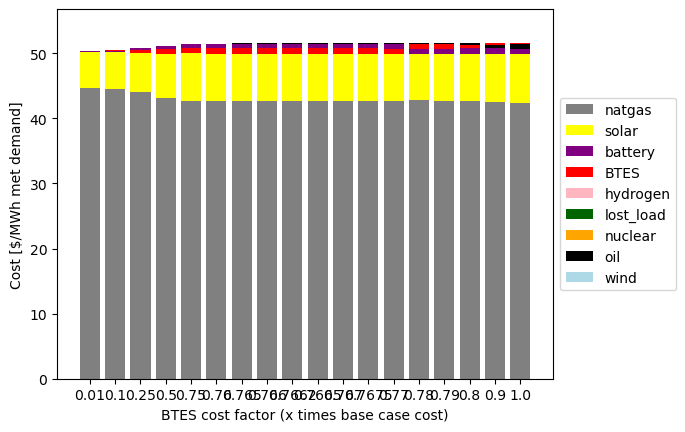

In [5]:
suffixes = ['']
region_names = ['isne']
cost_scan_var = 'BTES cost factor (x times base case cost)'

# for region_name in region_names:
for suffix in suffixes:
    output_path = 'output_data/btes_base_case_orca/'

    plot_cost_scan(output_path, "conus", cost_scan_var, suffix)

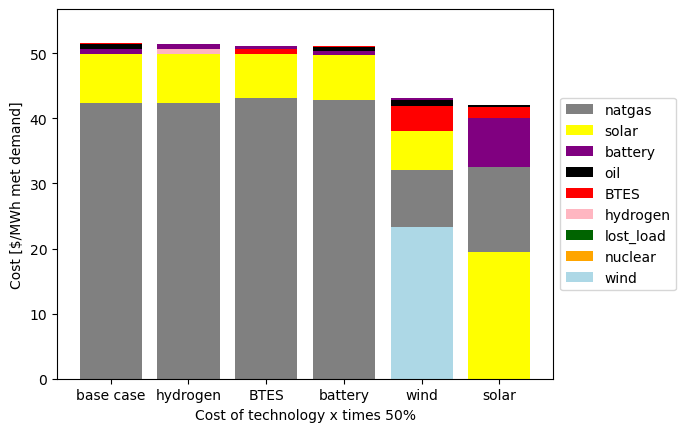

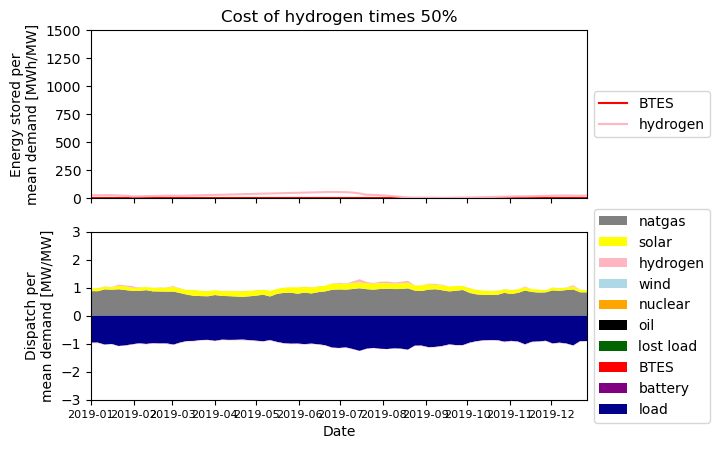

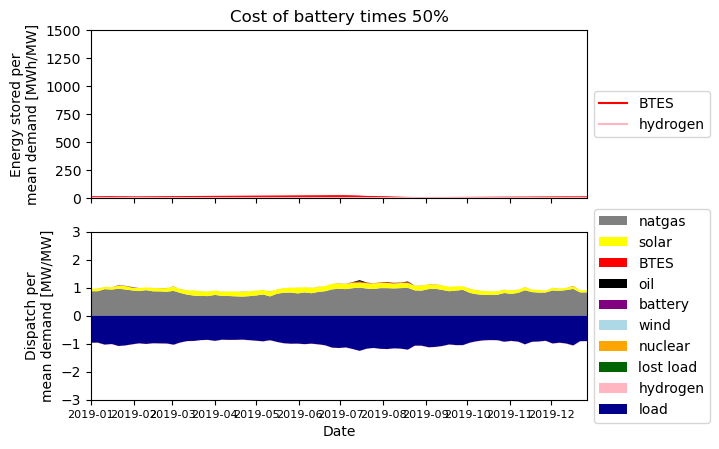

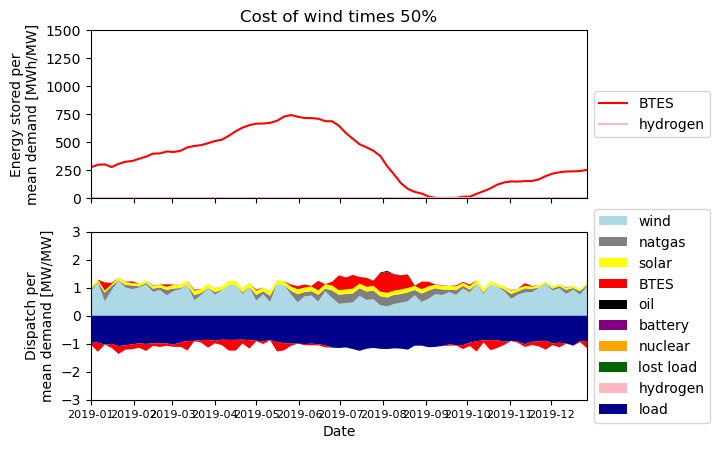

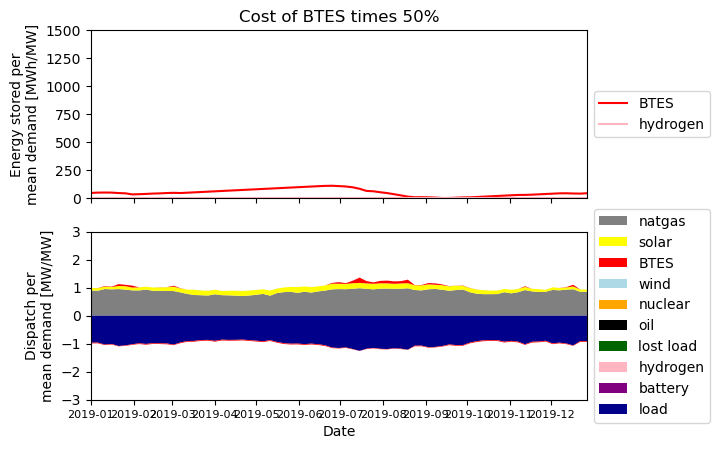

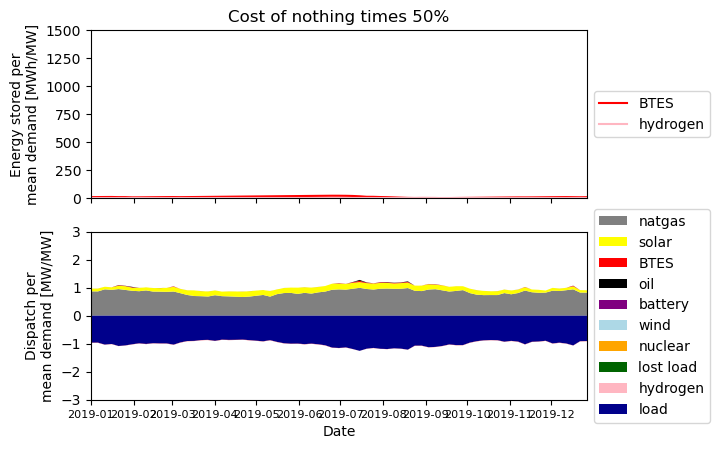

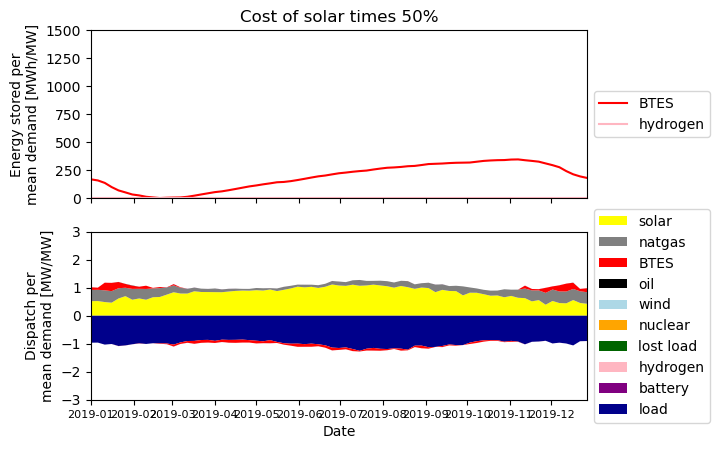

In [6]:
# Plot tech scan
out_path = 'output_data/btes_base_case_orca/tech_scan_0p5'
plot_cost_scan(out_path, "conus", 'Cost of technology x times 50%', suffix='_0p5', plot_dispatch=True)

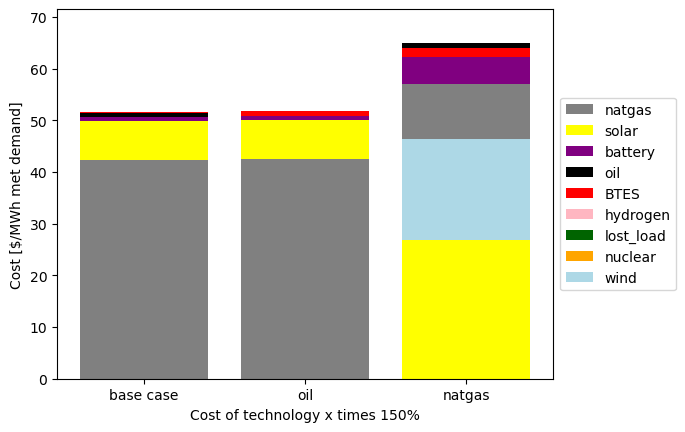

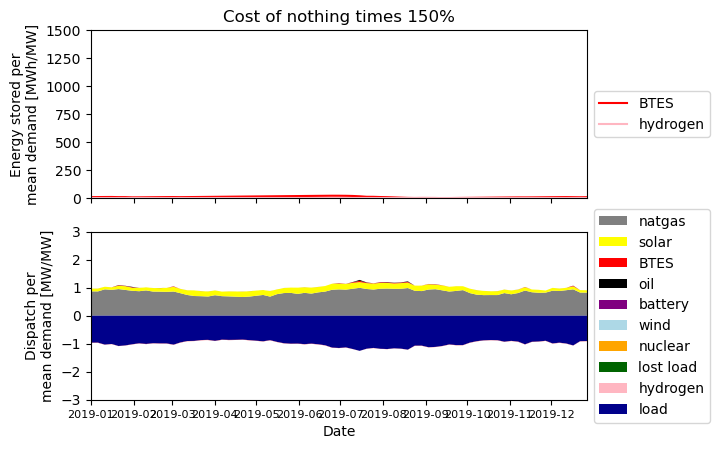

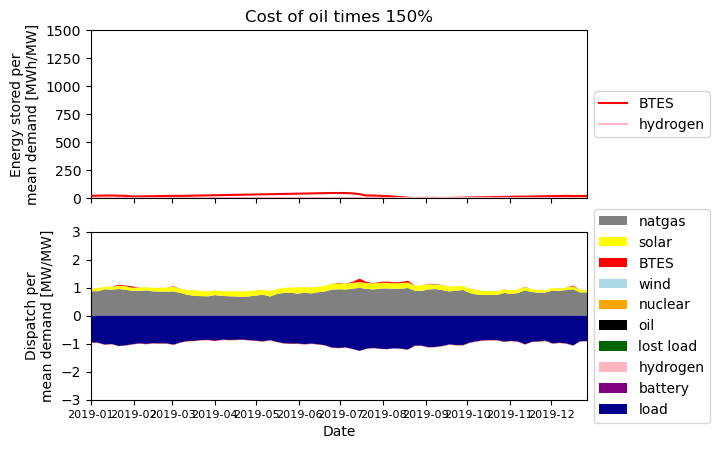

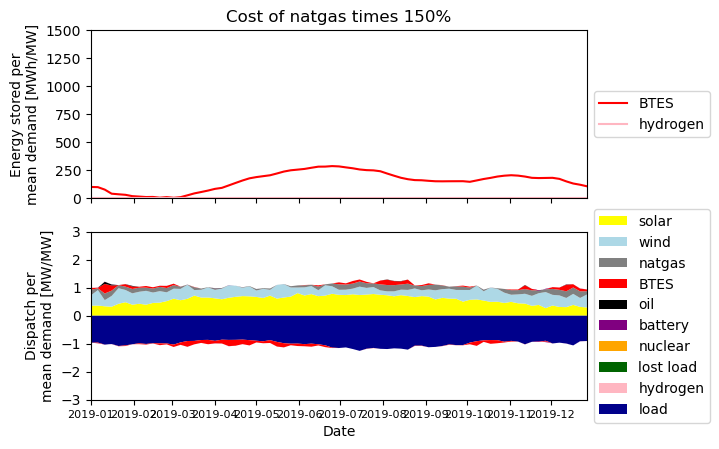

In [7]:
# Plot tech scan
out_path = 'output_data/btes_base_case_orca/tech_scan_1p5'
plot_cost_scan(out_path, "conus", 'Cost of technology x times 150%', suffix='_1p5', plot_dispatch=True)